# Census Income Prediction

The goal of this project is to determine the income level for an individual based on census data. The data includes features such as education, marital status, family origins, and finances. We will analyze the data then proceed to predicting income level using machine learning models. 

**Here is a breakdown of the sections of this notebook:**

1. Load Packages
2. Analyze Data
3. Feature Engineering
4. Initial Modeling
5. Feature Selection + Modeling
6. Oversampling + Modeling
7. Selected Model
8. Retrain on Full Training Data
9. Conclusion

**The best model was a LightGBM Classifier with the following model metrics:**

- Accuracy: 0.9476
- F1 Score (Weighted): 0.942
- Precision: 0.9419
- Recall: 0.9476

## Load Packages

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from lazypredict.Supervised import LazyClassifier
import optuna
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import RecursiveFeatureElimination
from imblearn.over_sampling import RandomOverSampler, SMOTE


## Load Data

In [2]:
raw_train = pd.read_csv("../data/census_income_learn.csv")
raw_test = pd.read_csv("../data/census_income_test.csv")

Things we can do:

- Add column names
- Format target variable
- Data structure: head, info, describe
- Confirm data types
- Remove duplicates
- Target class balance
- Missing values
- Summary stats
- Numerical features
    - Summary stats
    - Histogram / KDE plots
    - Univariate analysis (filtered by target)
    - Normality tests using Shapiro-Wilk test (not needed unless we want to use ANOVA)
    - Visuals (Boxplot, distribution plot, bar chart, pearson correlation)
- Outlier values
- Skewed values?
- Drop highly correlated features
- Drop constant features
- Categorical
    - Summary stats
    - Frequency counts
    - Relationship with target
- Re-binning categorical features
    - Bin low-frequency categories into "Other" group
    - Bin similar categories together
- Statistical dependence
    - Numerical: t-test (if normal) or Mann-Whitney U test
    - Categorical: chi square + Cramer's V
- Recap initial insights

## Analyze Data

This section is split into three parts:

1. Process data: This section is all about converting raw data into data that we can being analyzing.
2. Numerical Data: We will take a deeper look at our numerical features, how they relate to each other and target variable.
3. Categorical Data: We will look at the distribution of the target variable across different categories in our features.

### Process Data

- Add column names
- Format target variable
- Data structure: head, info, describe
- Confirm data types
- Remove duplicates
- Target class balance
- Missing values

In [ ]:
# List of column names

col_names = [
    "age",
    "class_of_worker",
    "detailed_industry_recode",
    "detailed_occupation_recode",
    "education",
    "wage_per_hour",
    "enroll_in_edu_inst_last_wk",
    "marital_stat",
    "major_industry_code",
    "major_occupation_code",
    "race",
    "hispanic_origin",
    "sex",
    "member_of_a_labor_union",
    "reason_for_unemployment",
    "full_or_part_time_employment_stat",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "tax_filer_stat",
    "region_of_previous_residence",
    "state_of_previous_residence",
    "detailed_household_and_family_stat",
    "detailed_household_summary_in_household",
    "instance_weight",
    "migration_code_change_in_msa",
    "migration_code_change_in_reg",
    "migration_code_move_within_reg",
    "live_in_this_house_1_year_ago",
    "migration_prev_res_in_sunbelt",
    "num_persons_worked_for_employer",
    "family_members_under_18",
    "country_of_birth_father",
    "country_of_birth_mother",
    "country_of_birth_self",
    "citizenship",
    "own_business_or_self_employed",
    "fill_inc_questionnaire_for_veteran's_admin",
    "veterans_benefits",
    "weeks_worked_in_year",
    "year",
    "income_classification"
]

In [4]:
# Assign column names to data
raw_train.columns = col_names
raw_test.columns = col_names

In [5]:
# Drop instance_weight since it should not be included in our classifiers
raw_train.drop(["instance_weight"], axis=1, inplace=True)
raw_test.drop(["instance_weight"], axis=1, inplace=True)

In [6]:
print(f"Training data target's unique values: {raw_train['income_classification'].unique()}")
print(f"Test data target's unique values: {raw_test['income_classification'].unique()}")

Training data target's unique values: [' - 50000.' ' 50000+.']
Test data target's unique values: [' - 50000.' ' 50000+.']


In [7]:
# Format target variable for training data
raw_train["target"] = np.where(
    raw_train["income_classification"] == " - 50000.",
    0,
    1
)

In [8]:
# Format target variable for test data
raw_test["target"] = np.where(
    raw_test["income_classification"] == " - 50000.",
    0,
    1
)

In [9]:
# Drop income_classification column
raw_train.drop(["income_classification"], axis=1, inplace=True)
raw_test.drop(["income_classification"], axis=1, inplace=True)

In [10]:
# Take a look at the columns
raw_train.head(5)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,target
0,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
1,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
2,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
3,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,0


In [11]:
print(f"The training data contains {raw_train.shape[0]} rows and {raw_train.shape[1]} columns.")
print(f"The test data contains {raw_test.shape[0]} rows and {raw_test.shape[1]} columns.")

The training data contains 199522 rows and 41 columns.
The test data contains 99761 rows and 41 columns.


In [12]:
# Ensure each column has the correct data type
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199522 entries, 0 to 199521
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype 
---  ------                                      --------------   ----- 
 0   age                                         199522 non-null  int64 
 1   class_of_worker                             199522 non-null  object
 2   detailed_industry_recode                    199522 non-null  int64 
 3   detailed_occupation_recode                  199522 non-null  int64 
 4   education                                   199522 non-null  object
 5   wage_per_hour                               199522 non-null  int64 
 6   enroll_in_edu_inst_last_wk                  199522 non-null  object
 7   marital_stat                                199522 non-null  object
 8   major_industry_code                         199522 non-null  object
 9   major_occupation_code                       199522 non-null  object
 10  race    

In [ ]:
# Convert these int64 into objects
convert_to_obj = ["detailed_industry_recode", "detailed_occupation_recode", "own_business_or_self_employed", "veterans_benefits", "year"]

raw_train[convert_to_obj] = raw_train[convert_to_obj].astype(str)
raw_test[convert_to_obj] = raw_test[convert_to_obj].astype(str)

In [14]:
# Get rid of duplicates even in test data to avoid biasing evaluation metrics

print(f"Get rid of {raw_train.shape[0] - raw_train.drop_duplicates().shape[0]} duplicate entries in training data.")
print(f"Get rid of {raw_test.shape[0] - raw_test.drop_duplicates().shape[0]} duplicate entries in test data.")

raw_train.drop_duplicates(inplace=True)
raw_test.drop_duplicates(inplace=True)

Get rid of 46626 duplicate entries in training data.
Get rid of 20898 duplicate entries in test data.


In [15]:
# We have a major class imbalance
raw_train["target"].value_counts(normalize=True)

target
0   0.92
1   0.08
Name: proportion, dtype: float64

In [16]:
def missing_values_summary(df: pd.DataFrame, missing_value=" ?"):
    """
    Returns a DataFrame with columns for count and percentage of custom missing values,
    sorted by the highest percentage of missing values.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        missing_value (str): The value to consider as missing (default is "?").
    
    Returns:
        pd.DataFrame: Summary of missing values.
    """
    missing_count = df.isin([missing_value]).sum()  # Count occurrences of the missing value
    total_rows = len(df)
    missing_percentage = (missing_count / total_rows)
    
    missing_summary = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Proportion': missing_percentage
    })
    
    # Filter to only include columns with missing values and sort by percentage
    missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
    missing_summary = missing_summary.sort_values(by='Missing Proportion', ascending=False)
    
    return missing_summary

In [17]:
missing_values_summary(raw_train)

,Missing Count,Missing Proportion
migration_code-change_in_msa,74944,0.49
migration_code-change_in_reg,74944,0.49
migration_code-move_within_reg,74944,0.49
migration_prev_res_in_sunbelt,74944,0.49
country_of_birth_father,6383,0.04
country_of_birth_mother,5810,0.04
country_of_birth_self,3322,0.02
state_of_previous_residence,698,0.00


We have 8 features that contain "?" entries which we suspect to be a proxy for missing values. We must handle these values with care; "?" may contain information. Models liek Random Forest and XGBoost can learn from "missingness" as its own unique pattern. I would lean towards imputing value rather than dropping them. Before imputing, you must understand the missingness pattern of your feature. If your feature is not missing data completely at random (MCAR), imputing could distort relationships in the data.

There are "Not in universe" values, but I don't consider this to be a missing value. It provide us useful information if we retain it as a value.

### Numerical Data

- Numerical features
    - Summary stats
    - Histogram / KDE plots
    - Univariate analysis (filtered by target)
    - Normality tests using Shapiro-Wilk test (not needed unless we want to use ANOVA)
    - Visuals (Boxplot, distribution plot, bar chart, pearson correlation)
- Outlier values
- Skewed values?
- Drop highly correlated features
- Drop constant features
- Statistical dependence
    - Numerical: t-test (if normal) or Mann-Whitney U test

In [18]:
# Let's look at summary statistics
raw_train.drop("target", axis=1).select_dtypes("int").describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.999]).transpose()

,count,mean,std,min,25%,50%,75%,95%,99%,99.5%,99.9%,max
age,152896.00,39.72,19.66,0.00,25.00,38.00,52.00,75.00,86.00,89.00,90.00,90.00
wage_per_hour,152896.00,72.32,312.07,0.00,0.00,0.00,0.00,650.00,1530.00,1850.52,2700.00,9999.00
capital_gains,152896.00,567.24,5359.20,0.00,0.00,0.00,0.00,0.00,14084.00,15024.00,99999.00,99999.00
capital_losses,152896.00,48.66,309.51,0.00,0.00,0.00,0.00,0.00,1944.00,2163.00,2603.00,4608.00
dividends_from_stocks,152896.00,257.02,2261.41,0.00,0.00,0.00,0.00,672.00,5751.95,10000.00,30000.00,99999.00
num_persons_worked_for_employer,152896.00,2.54,2.40,0.00,0.00,2.00,5.00,6.00,6.00,6.00,6.00,6.00
weeks_worked_in_year,152896.00,30.06,23.79,0.00,0.00,45.00,52.00,52.00,52.00,52.00,52.00,52.00


- It looks like wage_per_hour, capital_gains, and dividends_from_stocks have artificial upper limits.
- 75th percentile for wage_per_hour, capital_gains, capital_losses, and dividends_from_stocks are zero but the means for all four columns are greater than zero. Classic cases of data that are skewed right with large outlier values. 

Let's check what the second highest values are for some of the numerical columns to see how exaggerated the aritificial upper limits are.

In [19]:
raw_train[raw_train["wage_per_hour"] != raw_train["wage_per_hour"].max()]["wage_per_hour"].max()

np.int64(9916)

In [20]:
raw_train[raw_train["capital_gains"] != raw_train["capital_gains"].max()]["capital_gains"].max()

np.int64(41310)

In [21]:
raw_train[raw_train["capital_losses"] != raw_train["capital_losses"].max()]["capital_losses"].max()

np.int64(4356)

In [22]:
raw_train[raw_train["dividends_from_stocks"] != raw_train["dividends_from_stocks"].max()]["dividends_from_stocks"].max()

np.int64(95095)

I still think wage_per_hour, capital_gains, and dividends_from_stocks have artificial upper limits. For capital_gains, the artificial upper limit excessively extends the range.

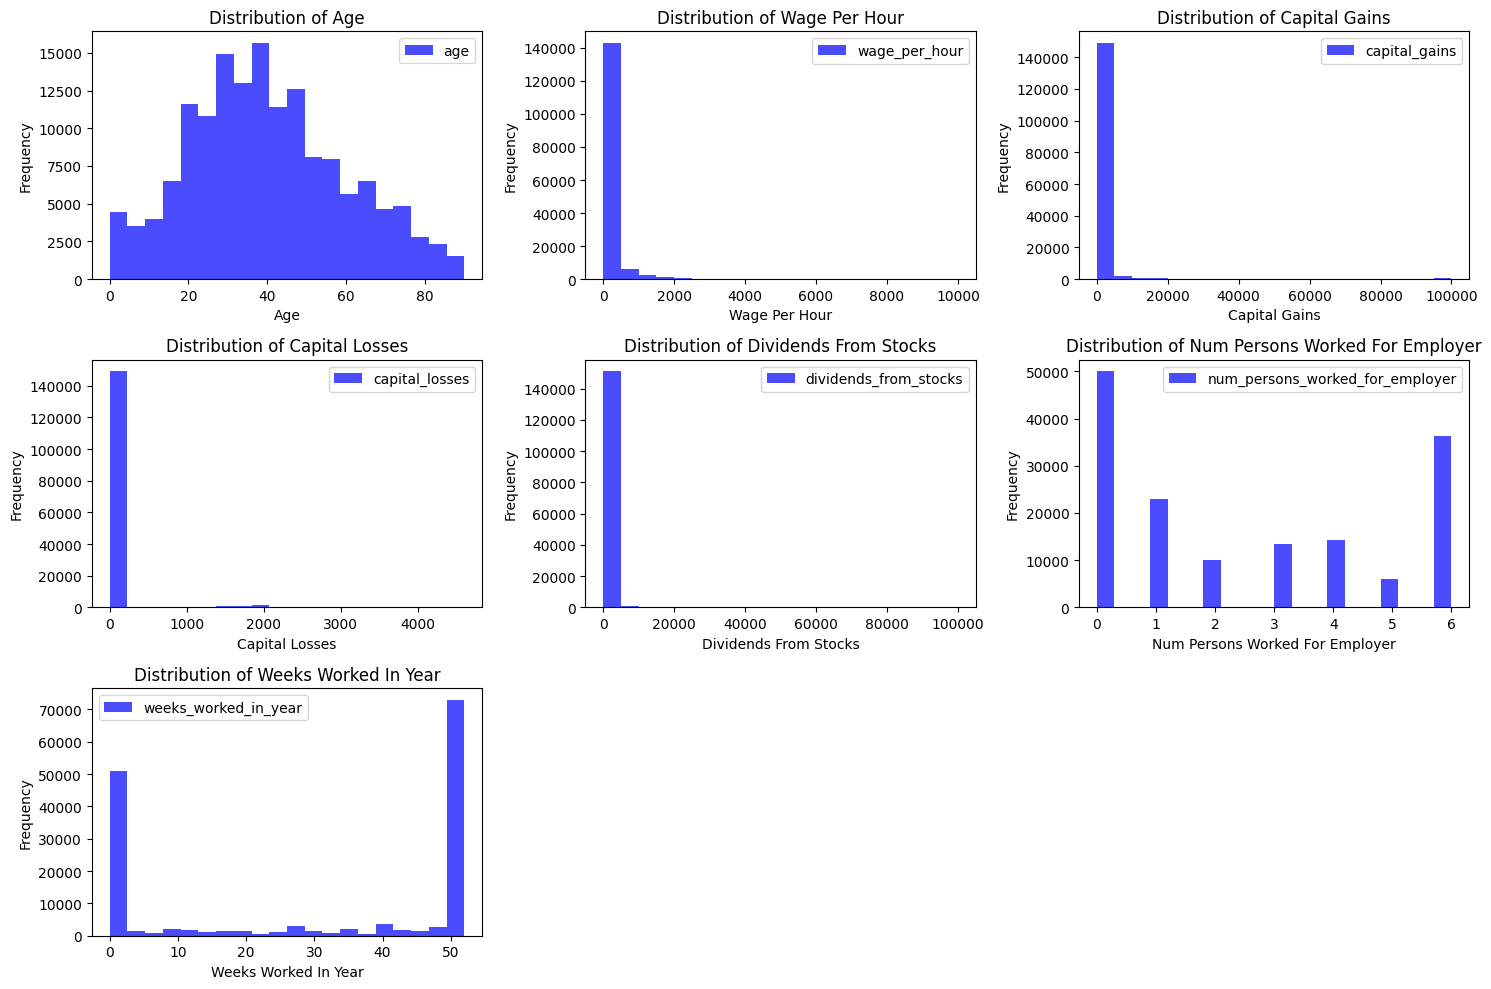

In [23]:
# Column names for histograms
columns_to_plot = [
    "age",
    "wage_per_hour",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "num_persons_worked_for_employer",
    "weeks_worked_in_year",
]

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot histograms
for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    ax.hist(raw_train[column], bins=20, alpha=0.7, label=column, color="blue")
    ax.set_title(f"Distribution of {column.replace('_', ' ').title()}")
    ax.set_xlabel(column.replace("_", " ").title())
    ax.set_ylabel("Frequency")
    ax.legend()

# Remove extra subplots
for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

We see the same results as in the table. wage_per_hour, capital_gains, capital_losses, and dividends_from_stocks have all their values primarily around zero. weeks_worked_in_year and num_persons_worked_for_employer both peak on both the lowest and highest extremes. Age is potentially normally distributed if not just a bit skewed.

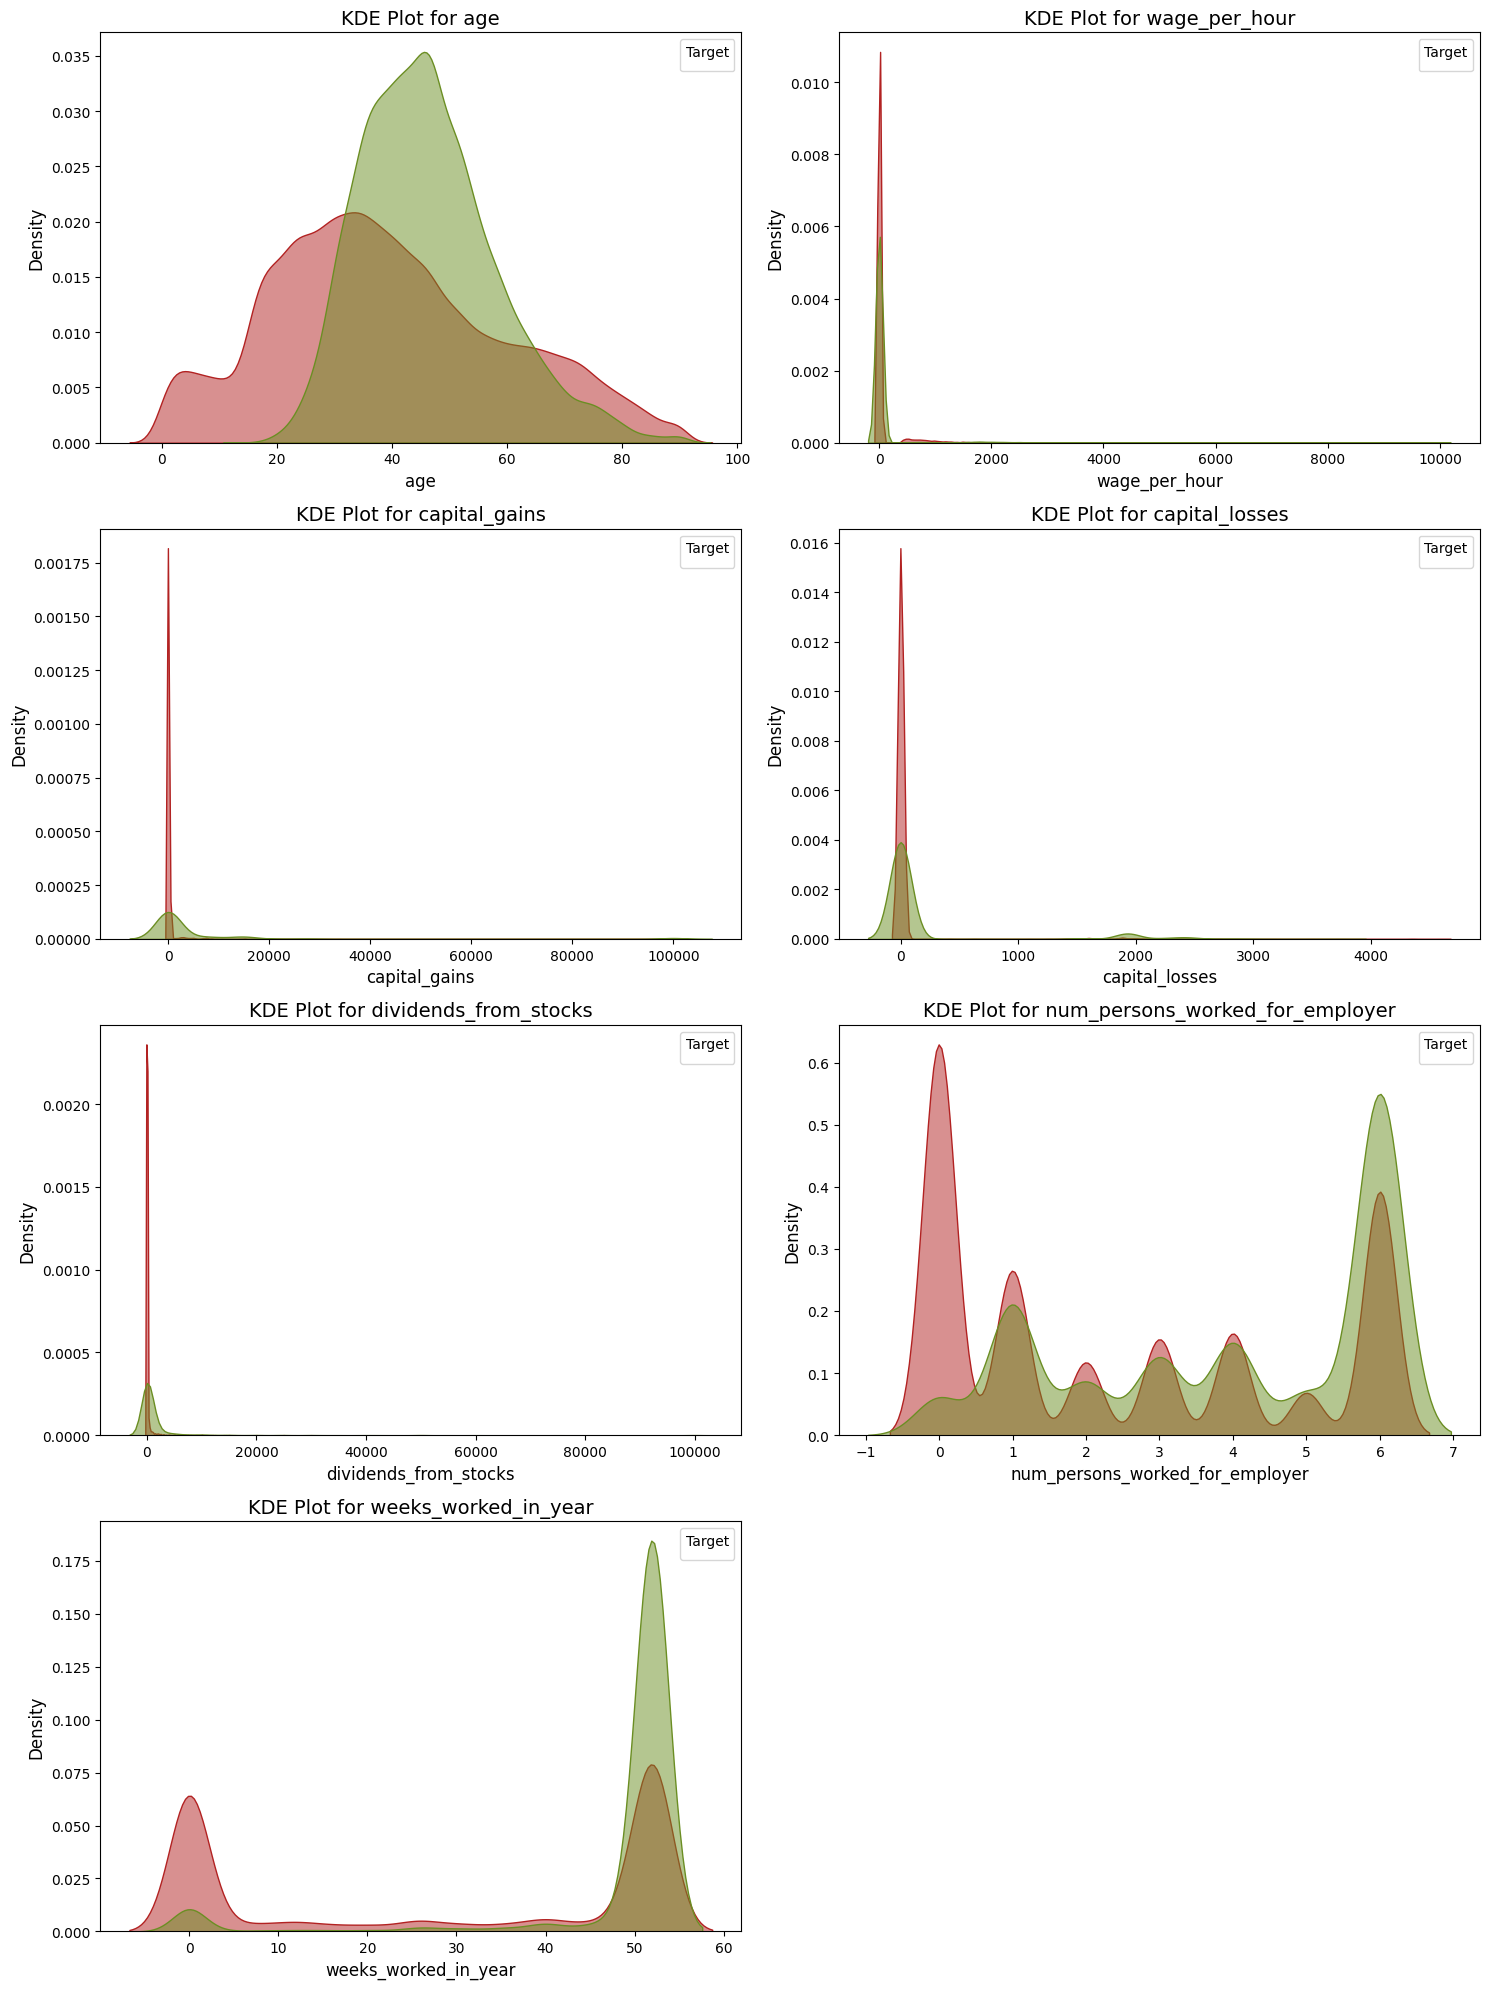

In [ ]:
# Adjusting the KDE plots to include legends
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.delaxes(axes[3, 1])  # Remove the extra subplot

# Flatten the axes array for easier iteration
axes = axes.ravel()

columns = [
    "age", 
    "wage_per_hour", 
    "capital_gains", 
    "capital_losses",
    "dividends_from_stocks", 
    "num_persons_worked_for_employer",
    "weeks_worked_in_year"
]

# Generate KDE plots with legends
for i, column in enumerate(columns):
    sns.kdeplot(data=raw_train[raw_train["target"] == 0], x=column, color="firebrick", fill=True, common_norm=False, alpha=0.5, ax=axes[i])
    sns.kdeplot(data=raw_train[raw_train["target"] == 1], x=column, color="olivedrab", fill=True, common_norm=False, alpha=0.5, ax=axes[i])
    axes[i].set_title(f"KDE Plot for {column}", fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel("Density", fontsize=12)
    axes[i].legend(title="Target", loc="upper right")

plt.tight_layout()
plt.show()

**Red**: Income below $50K\
**Green** Income above $50K

Now we break down distribution by income class. Some quick takeaways:

- Older people tend to earn above $50K more than younger people.
- Having 6 working people for an employer can lead to higher chance of earning above $50K and having 0 skyrockets earning lower than $50K.
- Working around 50-52 weeks can lead to higher chance of earning above $50K and working 0 skyrockets earning lower than $50K.

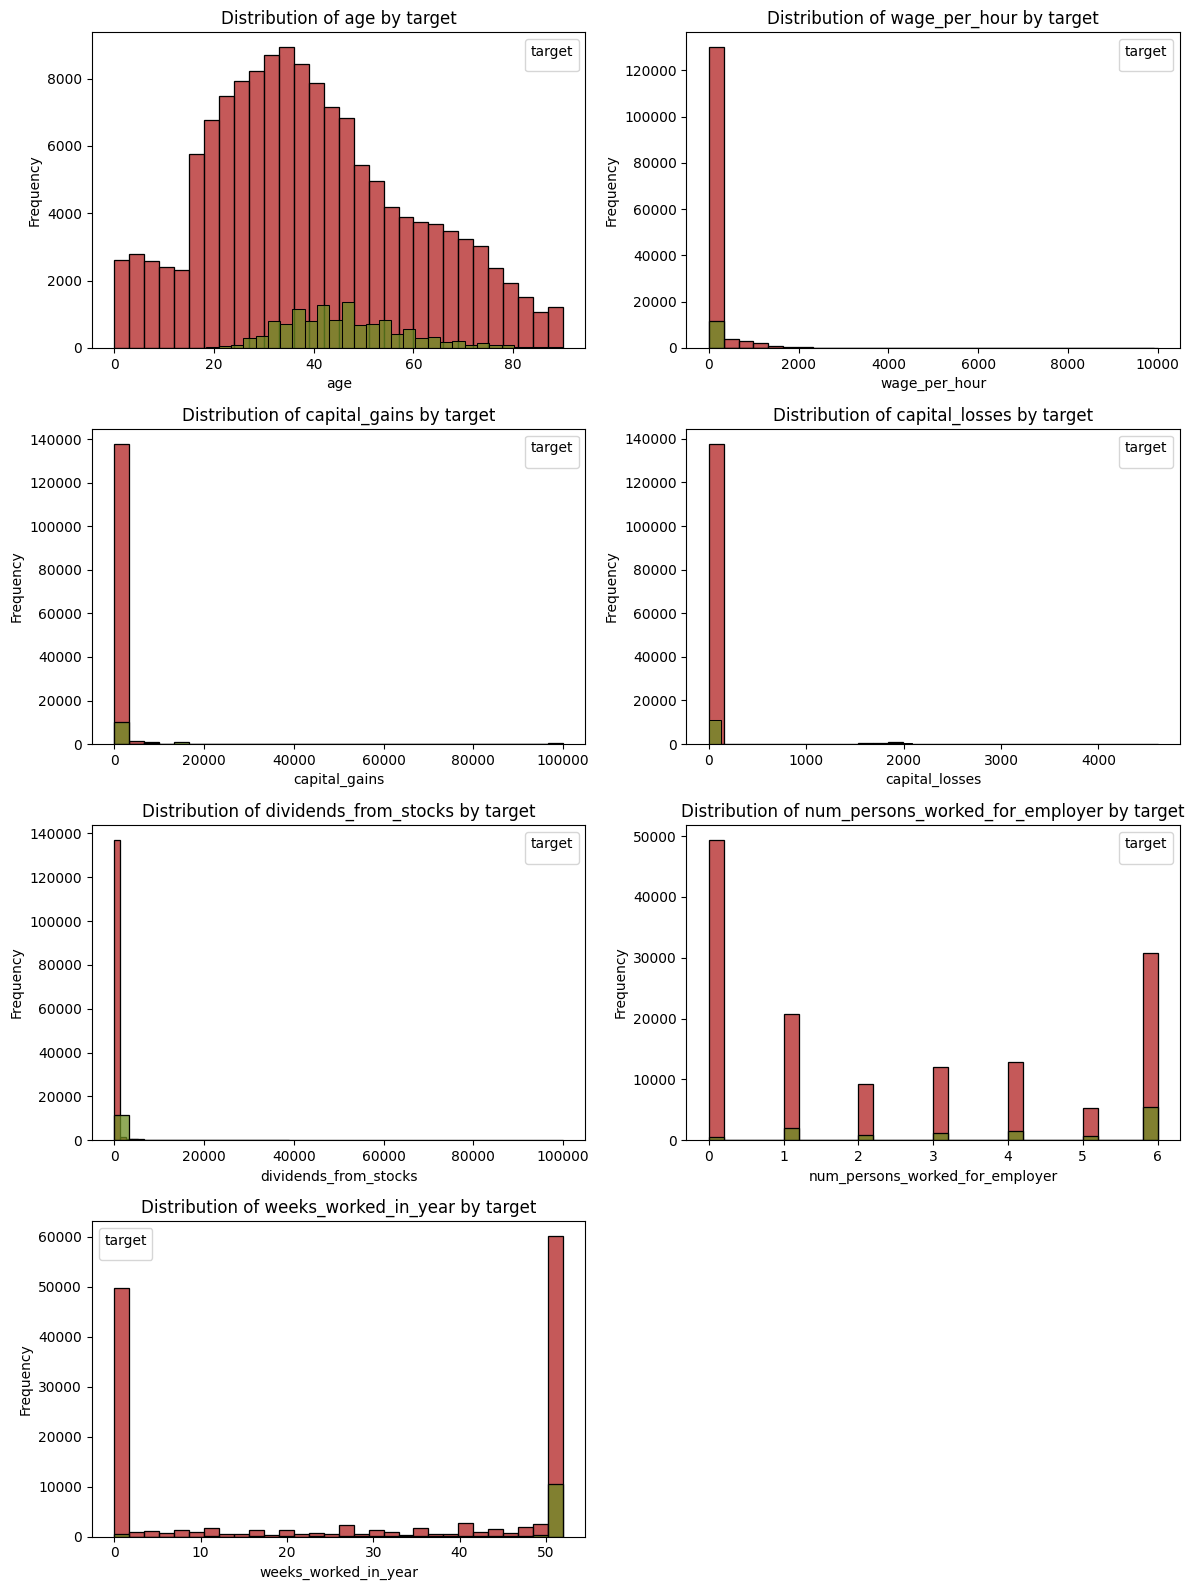

In [25]:
# Define numerical columns and the target variable
numerical_features = [
    "age",
    "wage_per_hour",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "num_persons_worked_for_employer",
    "weeks_worked_in_year"
]
target_variable = "target"  

# Set up the figure and axes for subplots
n_cols = 2
n_rows = (len(numerical_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4), tight_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Create histograms for each numerical column
for i, column in enumerate(numerical_features):
    ax = axes[i]
    sns.histplot(data=raw_train[raw_train["target"] == 0], x=column, color="firebrick", kde=False, element="bars", ax=ax, bins=30)
    sns.histplot(data=raw_train[raw_train["target"] == 1], x=column, color="olivedrab", kde=False, element="bars", ax=ax, bins=30)
    ax.set_title(f"Distribution of {column} by {target_variable}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")
    ax.legend(title=target_variable)

# Remove unused subplots if any
for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])

**Red**: Income below $50K\
**Green** Income above $50K

Takeaways are similar to previous plots.

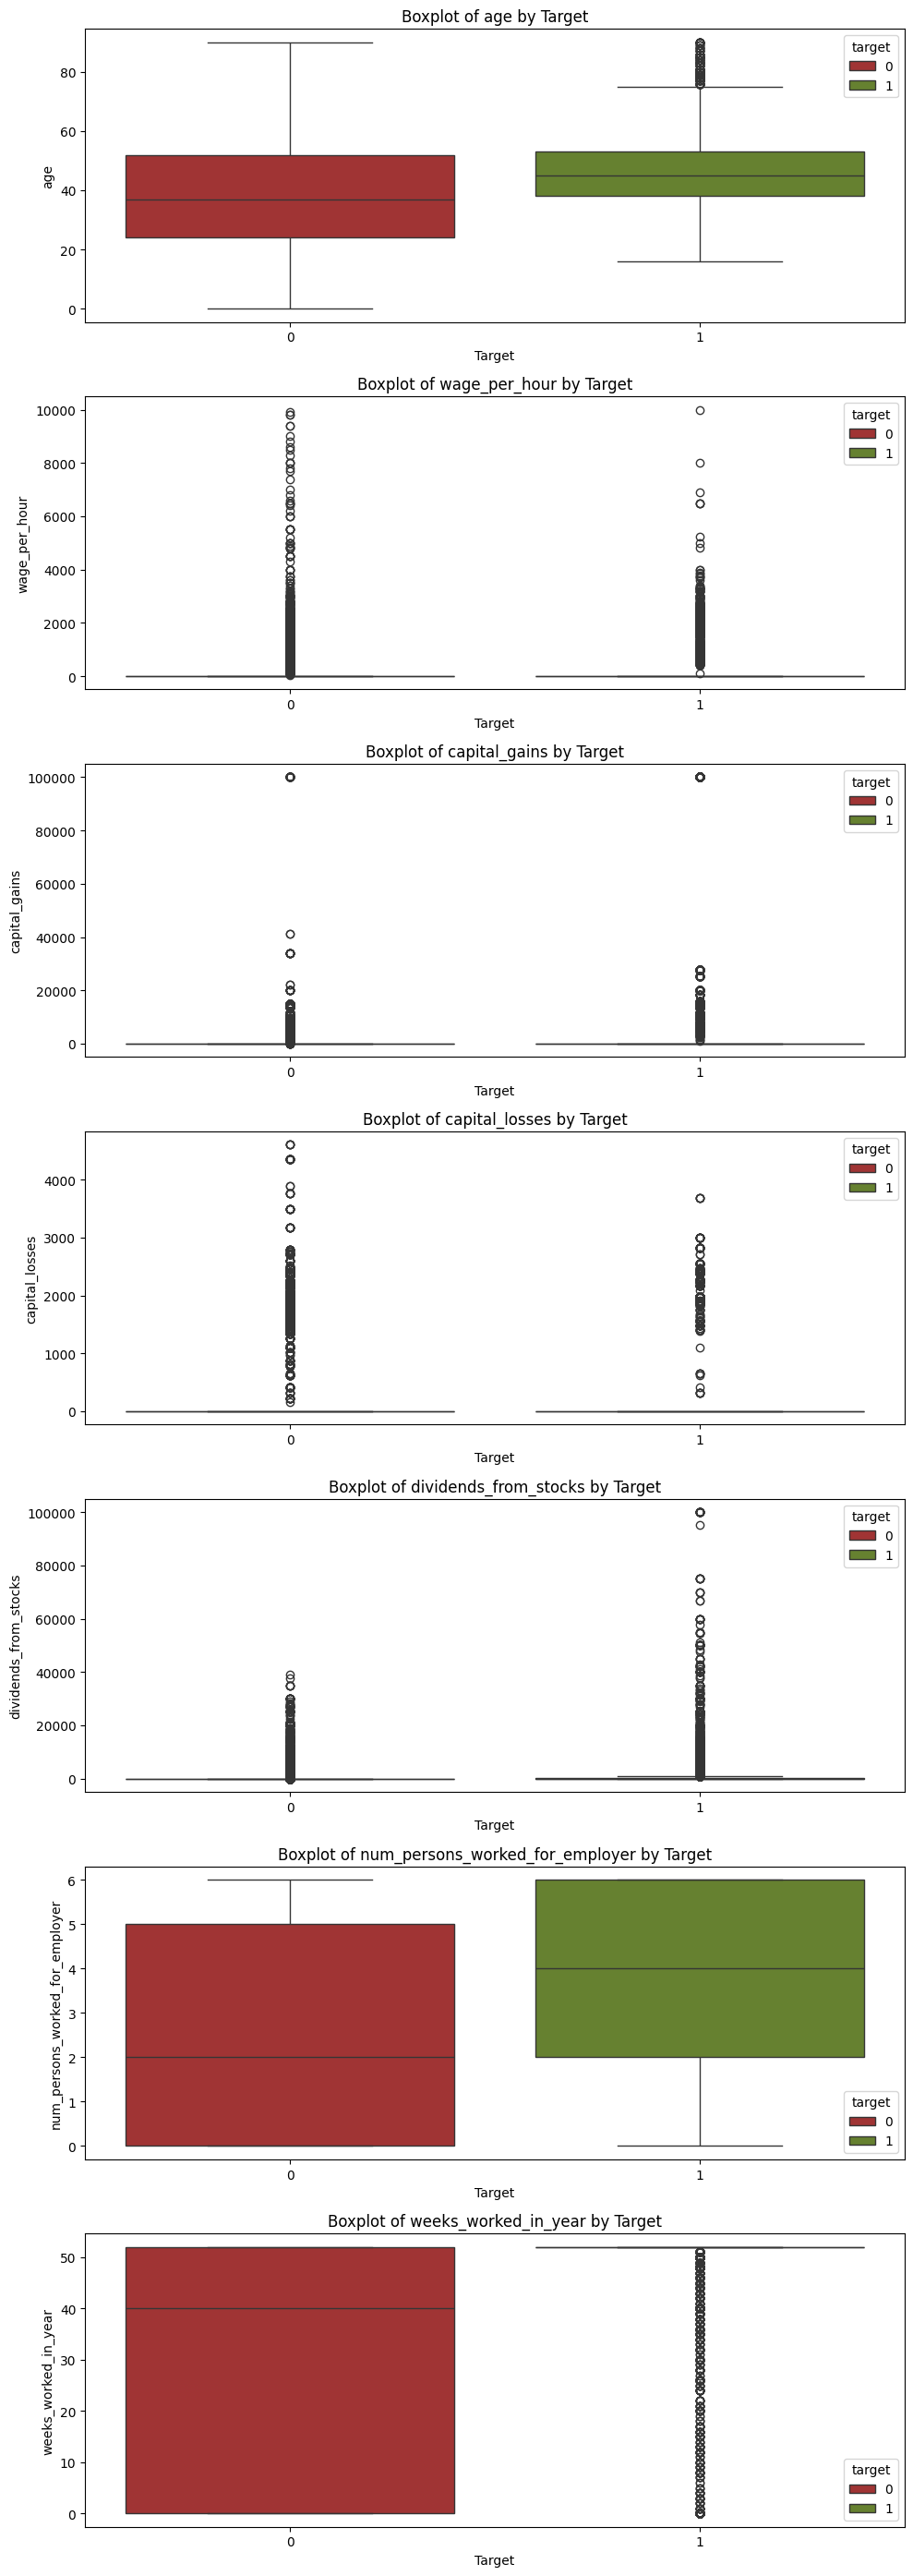

In [26]:
# Create subplots
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(10, 4 * len(numerical_features)))

# Plot boxplots
for i, col in enumerate(numerical_features):
    sns.boxplot(data=raw_train, x="target", y=col, hue="target", palette=["firebrick", "olivedrab"], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col} by Target")
    axes[i].set_xlabel("Target")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

age and num_persons_worked_for_employer show a bit of a difference between the two target classes. 

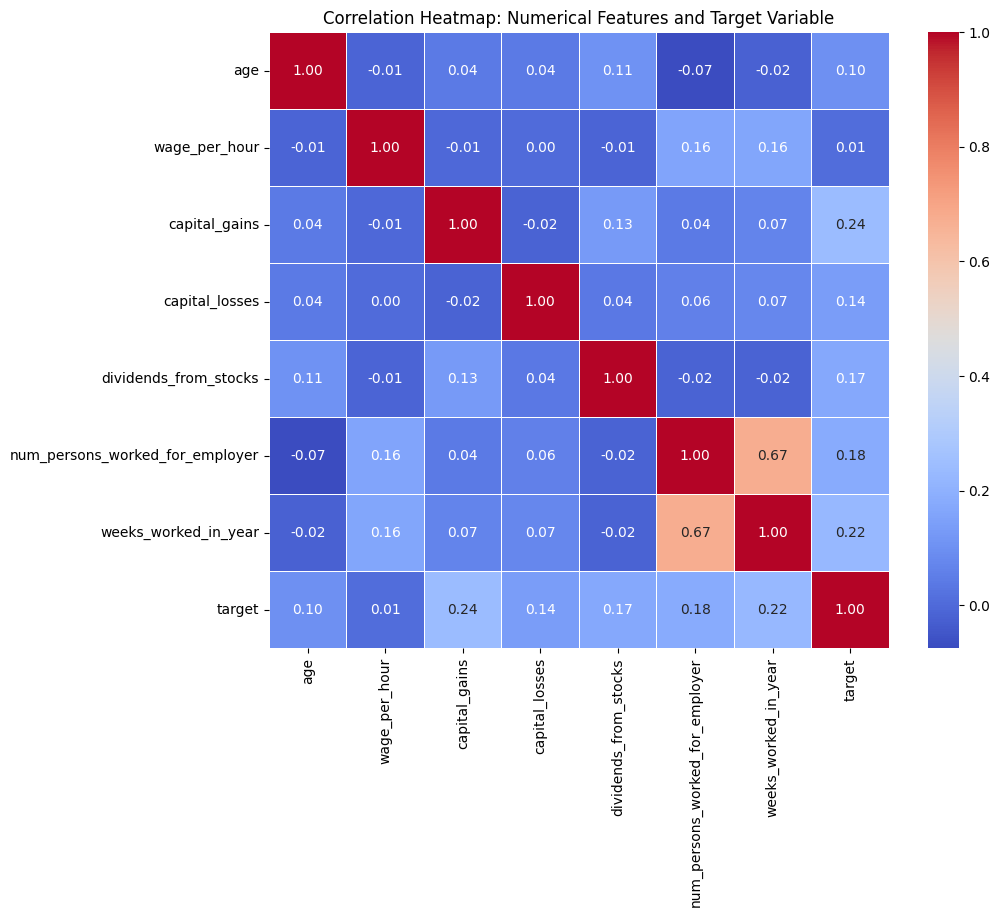

In [27]:
# Include the target variable in the correlation matrix
columns_to_correlate = numerical_features + ["target"]
# Pearson correlation is scale-invariant so no need to normalize/standardize
correlation_matrix = raw_train[columns_to_correlate].corr(method="pearson")

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar=True,
    linewidths=0.5,
)
plt.title("Correlation Heatmap: Numerical Features and Target Variable")
plt.show()

Mostly weak correlations with the target variable. There is a moderate connection between num_persons_worked_for_employer and weeks_worked_in_year have a Pearson correlation of 0.67. We won't drop one of them because models like Random Forest and XGBoost can handle multicollinearity and thee two features might be capturing different patterns.

In [28]:
dcf_num = DropConstantFeatures(tol=1)
dcf_num.fit_transform(raw_train.drop("target", axis=1).select_dtypes("int"))


,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year
0,58,0,0,0,0,1,52
1,18,0,0,0,0,0,0
2,9,0,0,0,0,0,0
3,10,0,0,0,0,0,0
4,48,1200,0,0,0,1,52
...,...,...,...,...,...,...,...
199516,39,0,6849,0,0,6,52
199517,87,0,0,0,0,0,0
199518,65,0,6418,0,9,1,52
199519,47,0,0,0,157,6,52


In [29]:
numerical_features = [
    "age", "wage_per_hour", "capital_gains", "capital_losses", 
    "dividends_from_stocks", "num_persons_worked_for_employer", 
    "weeks_worked_in_year"
]
target = "target"

results = {}

# Split data into two groups based on the target
under_50k = raw_train[raw_train[target] == 0]
over_50k = raw_train[raw_train[target] == 1]

# Loop through numerical features to run Mann-Whitney U Test
for feature in numerical_features:
    stat, p_value = stats.mannwhitneyu(under_50k[feature], over_50k[feature], alternative='two-sided')
    results[feature] = {'statistic': stat, 'p_value': p_value}

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results).T
results_df

,statistic,p_value
age,632744908.50,0.00
wage_per_hour,894444728.00,0.00
capital_gains,725235055.00,0.00
capital_losses,803102411.50,0.00
dividends_from_stocks,585113659.50,0.00
num_persons_worked_for_employer,529626141.00,0.00
weeks_worked_in_year,472434072.00,0.00


Takeaways:

- Outlier and Skewness: wage_per_hour, capital_gains, capital_losses, and dividends_from_stocks contain outliers and are heavily skewed right.
- Normality: None of these features look normally distributed but age looks close to being normally distributed.
- Correlated features: num_persons_worked_for_employer and weeks_worked_in_year have a Pearson correlation of 0.67.
- Constant features: At a 95% threshold, capital_gain and capital_losses are considering constant because of all the zero values. We will keep them for now.
- Statistical dependence: Show all features using Mann Whitney U test are statistically significant in distinguishing individuals who earn more than $50k from those who earn less. Results could be affected by outliers and extreme skewed data.


We have a better understanding of our data. I didn't want to drop any numerical features too early because I plan on using tree-based methods which are generally robust to issues like outliers and skewed data. We will use a feature selection method later after looking at categorical features.

### Categorical Data

- Categorical
    - Summary stats
    - Frequency counts
    - Relationship with target
- Re-binning categorical features
    - Bin low-frequency categories into "Other" group
    - Bin similar categories together
- Statistical dependence
    - Categorical: chi square + Cramer's V

In [31]:
# List of categorical features
categorical_features = raw_train.select_dtypes("object").columns.tolist()

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()  # Total number of observations
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Prepare an empty list to store the results
results = []

# Loop through all categorical features
for feature in categorical_features:
    # Create a contingency table for Chi-Square test
    contingency_table = pd.crosstab(raw_train[feature], raw_train["target"])
    
    # Perform Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate Cramér's V if Chi-Square is significant
    cramers_v_value = cramers_v(contingency_table)
    
    # Append the results to the list
    results.append({
        'Feature': feature,
        'Chi-Square p-value': p,
        'Cramers V': cramers_v_value
    })

# Convert the results to a DataFrame
cat_stat_results = pd.DataFrame(results)

# Optionally, sort by p-value to prioritize features with significant relationships
cat_stat_results = cat_stat_results.sort_values(by='Cramers V', ascending=False).reset_index(drop=True)

In [32]:
cat_stat_results

,Feature,Chi-Square p-value,Cramers V
0,detailed_occupation_recode,0.00,0.42
1,education,0.00,0.37
2,major_occupation_code,0.00,0.34
3,detailed_industry_recode,0.00,0.26
4,major_industry_code,0.00,0.24
5,class_of_worker,0.00,0.22
6,detailed_household_and_family_stat,0.00,0.21
7,tax_filer_stat,0.00,0.20
8,detailed_household_summary_in_household,0.00,0.20
9,sex,0.00,0.18


With Cramer's V, we can take 0.1 as the threshold for any relationship. Below 0.1 can be considered negligible. There are 12 features that are above the 0.1 threshold.

Let's take a deeper look at some of the categorical columns with an association to the target variable. We will only keep the more general category when there are two related columns (Example: detailed_occupation_recode and major_industry_code). The more general category is easier to visualize and analyze. We would need more time to dig deep into the detailed columns.

In [33]:
print(raw_train["detailed_occupation_recode"].nunique(), raw_train["major_occupation_code"].nunique())

47 15


In [34]:
print(raw_train["detailed_industry_recode"].nunique(), raw_train["major_industry_code"].nunique())

52 24


In [35]:
print(raw_train["detailed_household_and_family_stat"].nunique(), raw_train["detailed_household_summary_in_household"].nunique())

38 8


In [36]:
def percent_stacked_bar_chart(dataframe, target_column, categorical_column):
    """
    Creates a percent stacked bar chart for a target column and a categorical column.

    Parameters:
    dataframe (pd.DataFrame): The input data.
    target_column (str): The column used for the color grouping (e.g., "target").
    categorical_column (str): The column used for the x-axis (e.g., "education").
    """
    # Calculate the percentage distribution of the target column within each category
    category_target = dataframe.groupby([categorical_column, target_column]).size().unstack(fill_value=0)
    category_target_percentage = category_target.div(category_target.sum(axis=1), axis=0) * 100

    # Plot the percent stacked bar chart
    category_target_percentage.plot(kind="bar", stacked=True, figsize=(10, 6), color=["firebrick", "olivedrab"])

    # Add labels, title, and legend
    plt.title(f"Percent Stacked Bar Chart: {categorical_column.title()} vs {target_column.title()}", fontsize=16)
    plt.xlabel(categorical_column.title(), fontsize=12)
    plt.ylabel("Percentage", fontsize=12)
    plt.legend(title=target_column.title(), fontsize=10, bbox_to_anchor=(1.05, 0.5), loc="center left")
    plt.xticks(rotation=90, fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()


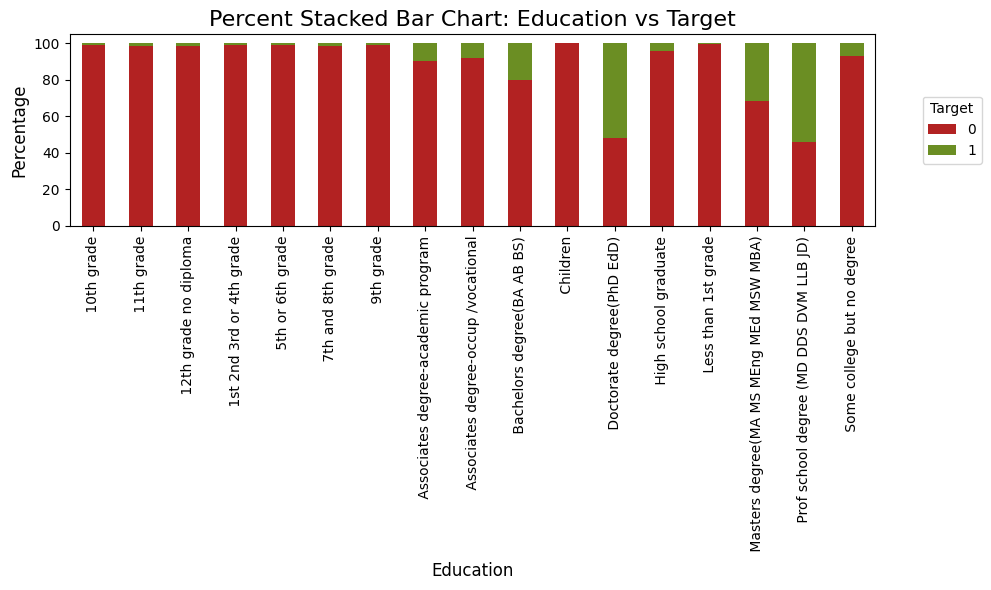

In [37]:
percent_stacked_bar_chart(raw_train, target_column="target", categorical_column="education")


Advanced degrees (PhD, Masters, and prof school degree) show the highest percentage of income above $50K.

In [38]:
raw_train["education"].value_counts()

education
High school graduate                      43642
Some college but no degree                26329
Bachelors degree(BA AB BS)                19391
Children                                  12710
10th grade                                 6487
Masters degree(MA MS MEng MEd MSW MBA)     6460
7th and 8th grade                          6309
11th grade                                 6213
Associates degree-occup /vocational        5249
9th grade                                  4976
Associates degree-academic program         4322
5th or 6th grade                           3139
12th grade no diploma                      2059
Prof school degree (MD DDS DVM LLB JD)     1791
1st 2nd 3rd or 4th grade                   1755
Doctorate degree(PhD EdD)                  1262
Less than 1st grade                         802
Name: count, dtype: int64

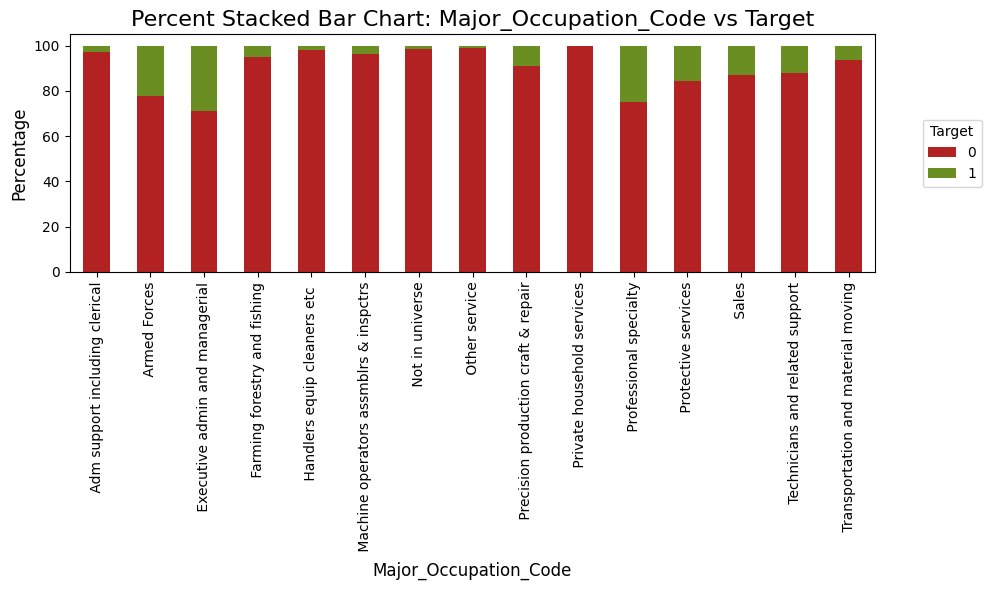

In [39]:
percent_stacked_bar_chart(raw_train, target_column="target", categorical_column="major_occupation_code")


Executive admin and managerial show the highest percentage of income above $50K.

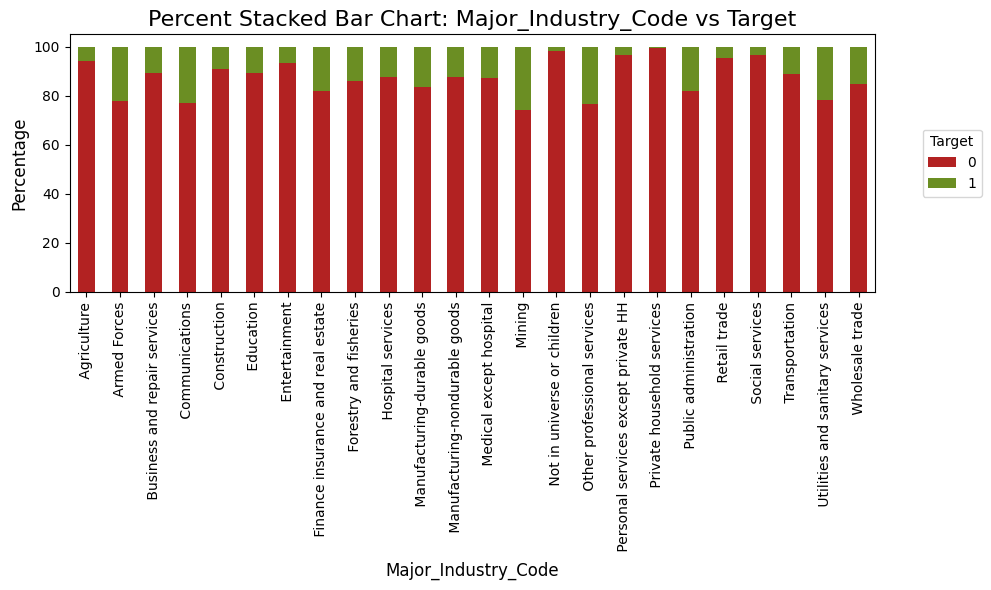

In [40]:
percent_stacked_bar_chart(raw_train, target_column="target", categorical_column="major_industry_code")


Mining, communication, and other professional services show the highest percentage of income above $50K.

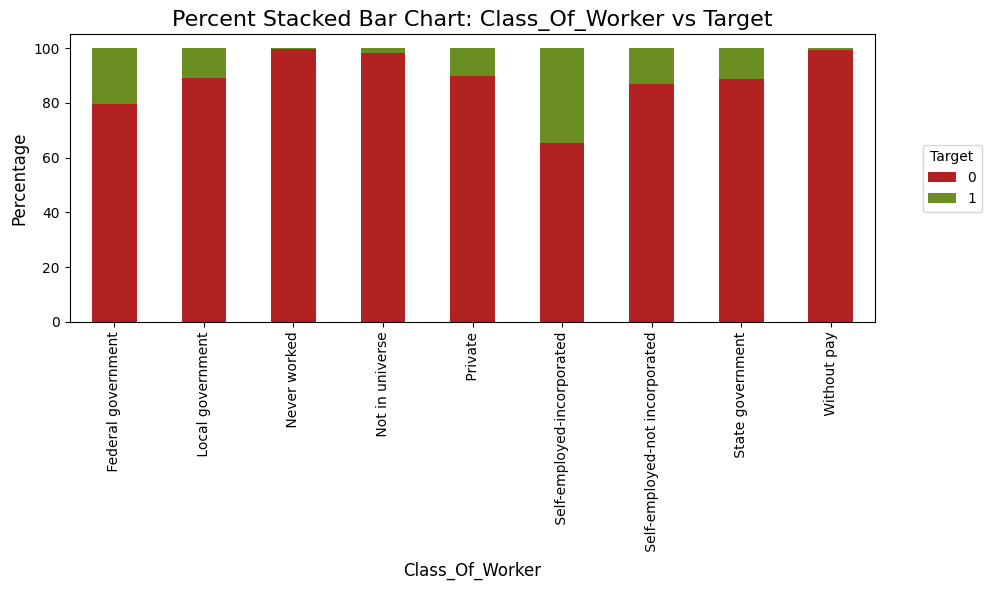

In [41]:
percent_stacked_bar_chart(raw_train, target_column="target", categorical_column="class_of_worker")

Self-employed-incorporated shows the highest percentage of income above $50K.

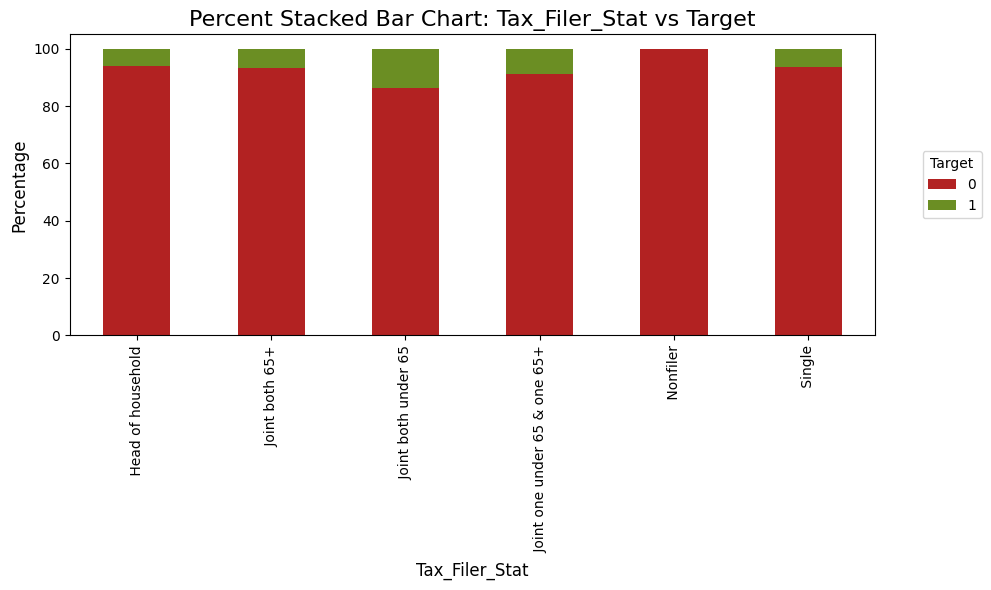

In [42]:
percent_stacked_bar_chart(raw_train, target_column="target", categorical_column="tax_filer_stat")

Joint both 65+ shows the highest percentage of income above $50K.

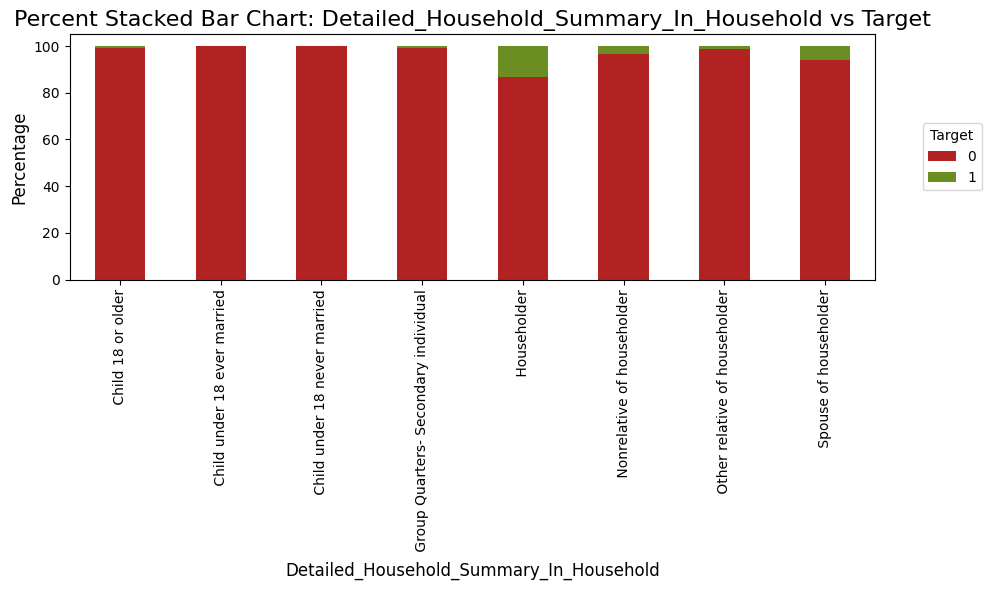

In [43]:
percent_stacked_bar_chart(raw_train, target_column="target", categorical_column="detailed_household_summary_in_household")

Householder shows the highest percentage of income above $50K.

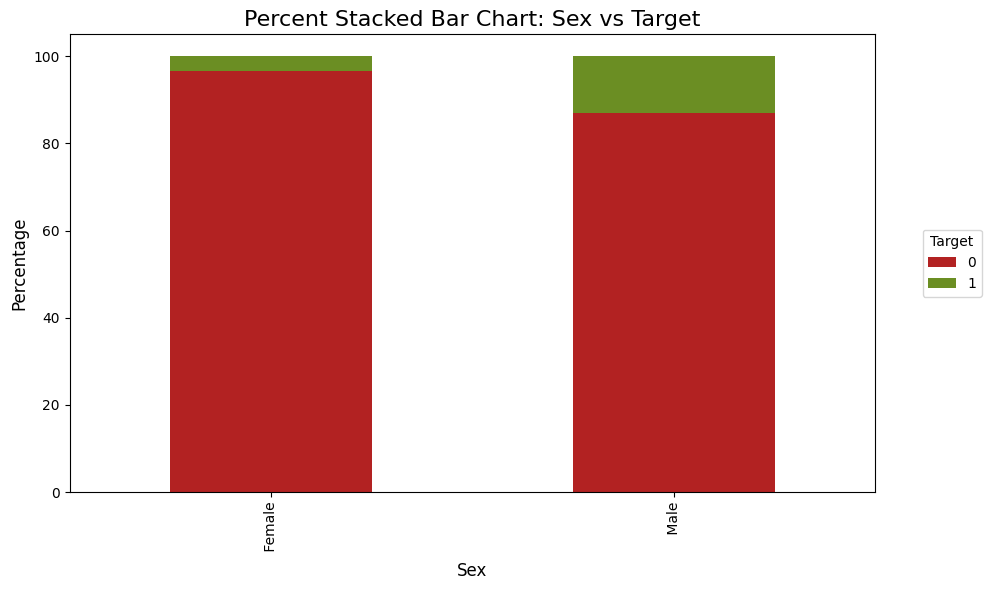

In [44]:
percent_stacked_bar_chart(raw_train, target_column="target", categorical_column="sex")

Male shows the highest percentage of income above $50K.

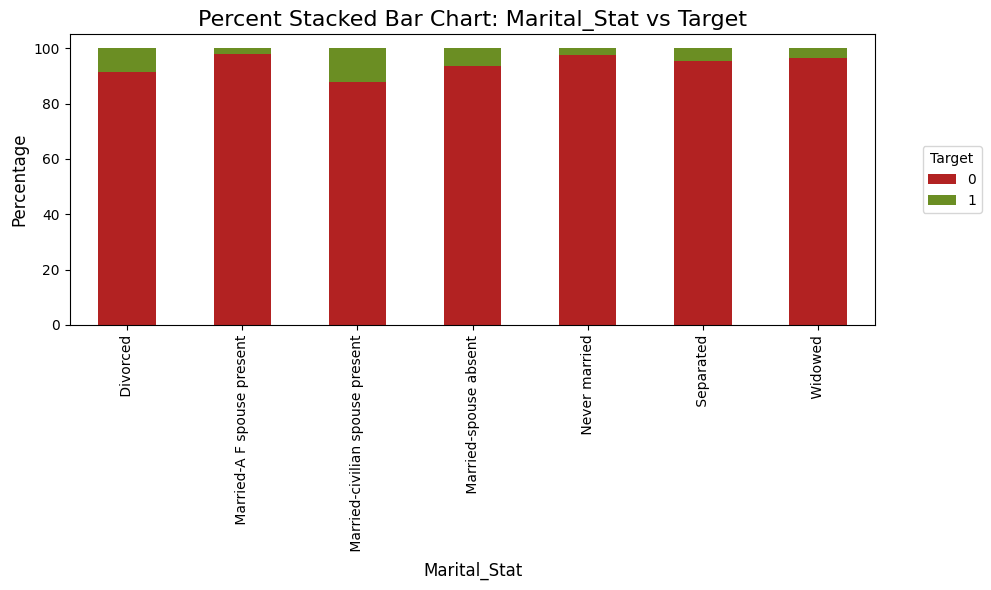

In [45]:
percent_stacked_bar_chart(raw_train, target_column="target", categorical_column="marital_stat")

Married-civilian-spouse-present shows the highest percentage of income above $50K.

Takeways:

- Cramer's V: There are 12 features that pass the 0.1 threshold meaning they have some sort of relationship with the target variable.
- Percent Stacked Bar Chart: We saw what categories within each feature had a slightly higher percentage of individuals making above $50K.

## Feature Engineering


Numerical Features:
- Handle outlier values
- Handle skewed values
- Drop highly correlated features
- Drop constant features
- Normalize values

Categorical Features:
- Re-binning categorical features
    - Bin low-frequency categories into "Other" group
    - Bin similar categories together
- Encoding categorical features


In [ ]:
# Order education since there is an inherent rank
education_order = [
    ' Children',
    ' Less than 1st grade',
    ' 1st 2nd 3rd or 4th grade',
    ' 5th or 6th grade',
    ' 7th and 8th grade',
    ' 9th grade',
    ' 10th grade',
    ' 11th grade',
    ' 12th grade no diploma',
    ' High school graduate',
    ' Some college but no degree',
    ' Associates degree-occup /vocational',
    ' Associates degree-academic program',
    ' Bachelors degree(BA AB BS)',
    ' Masters degree(MA MS MEng MEd MSW MBA)',
    ' Prof school degree (MD DDS DVM LLB JD)',
    ' Doctorate degree(PhD EdD)',
]

In [ ]:
# Ordinal encoder for education because it has a rank
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[education_order])),
    ('scaler', MinMaxScaler(copy=False))
])

In [ ]:
# All categorical features except education
categorical_features_ohe = [col for col in categorical_features if col != "education"]

In [192]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        # OneHotEncoder for categorical columns
        ('cat', OneHotEncoder(), categorical_features_ohe),
        
        # OrdinalEncoder for education column 
        ('edu', ordinal_transformer, ["education"]),
        
        # MinMaxScaler for numeric columns
        ('num', MinMaxScaler(copy=False), numerical_features)
    ]
)

This is our simple feature engineering with a focus on converting data into numerical values between 0 and 1. Now, our data can be fed into any machine learning model and all features have a constant scale.

In [193]:
processed_data = preprocessor.fit_transform(raw_train)

In [51]:
type(processed_data)

scipy.sparse._csr.csr_matrix

processed_data is a scipy.sparse._csr.csr_matrix object so let's convert it back into a Pandas dataframe so we can keep column names.

In [52]:
# Get the column names after transformation
cat_columns = preprocessor.transformers_[0][1].get_feature_names_out(categorical_features_ohe)
all_columns = list(cat_columns) + ['education'] + numerical_features

# Create a DataFrame with the transformed data
processed_df = pd.DataFrame.sparse.from_spmatrix(processed_data, columns=all_columns)

## Initial Modeling

In [242]:
# Dataframe of features
X = raw_train.drop("target", axis=1)
# Extract the target variable values
y = raw_train["target"]

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [243]:
# Let's try five different models
classifiers_to_train = [
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    LGBMClassifier,
]

In [244]:
# LazyClassifier will train multiple models quickly
clf = LazyClassifier(verbose=1, ignore_warnings=False, classifiers=classifiers_to_train)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

 20%|██        | 1/5 [00:10<00:40, 10.03s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.9296926095487247, 'Balanced Accuracy': np.float64(0.5988142510330883), 'ROC AUC': np.float64(0.5988142510330883), 'F1 Score': 0.9107299869819391, 'Time taken': 10.02969217300415}


 40%|████      | 2/5 [00:12<00:17,  5.87s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.9087965990843688, 'Balanced Accuracy': np.float64(0.7142924378925428), 'ROC AUC': np.float64(0.7142924378925427), 'F1 Score': 0.9105290556600171, 'Time taken': 2.952935218811035}


 60%|██████    | 3/5 [00:24<00:16,  8.36s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9365598430346632, 'Balanced Accuracy': np.float64(0.6774494222025931), 'ROC AUC': np.float64(0.6774494222025931), 'F1 Score': 0.9271368683540723, 'Time taken': 11.328983783721924}


 80%|████████  | 4/5 [01:07<00:22, 22.08s/it]

{'Model': 'GradientBoostingClassifier', 'Accuracy': 0.9392086330935252, 'Balanced Accuracy': np.float64(0.6873352528195036), 'ROC AUC': np.float64(0.6873352528195036), 'F1 Score': 0.9302899933427327, 'Time taken': 43.11535310745239}


100%|██████████| 5/5 [01:10<00:00, 14.02s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.9424787442773054, 'Balanced Accuracy': np.float64(0.7230759584077662), 'ROC AUC': np.float64(0.7230759584077663), 'F1 Score': 0.9364269553518922, 'Time taken': 2.6642849445343018}


In [ ]:
# LGBMClassifier is a clear winner
models.sort_values("Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.94,0.72,0.72,0.94,3.22
GradientBoostingClassifier,0.94,0.69,0.69,0.93,40.24
RandomForestClassifier,0.94,0.68,0.68,0.93,10.99
LogisticRegression,0.93,0.60,0.60,0.91,15.28
DecisionTreeClassifier,0.91,0.71,0.71,0.91,2.90


lazypredict let's you train a bunch of machine learning models quickly. It uses a simple sklearn pipeline to process the data then trains on default hyperparameters. The output is the table above.

We will pick one bagging and one boosting method to explore further. Let's select LGBMClassifier and RandomForestClassifier.

In [56]:
# Dataframe of features
X = processed_data
# Extract the target variable values
y = raw_train["target"].values

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [70]:
print(metrics.accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="weighted"))

0.937083060824068 0.9276958880869104


In [ ]:
# Train LightGBM Classifier
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

[LightGBM] [Info] Number of positive: 9884, number of negative: 112432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 122316, number of used features: 480
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080807 -> initscore=-2.431431
[LightGBM] [Info] Start training from score -2.431431


In [77]:
print(metrics.accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="weighted"))

0.9428057553956835 0.9368210153149664


Now, let's use optuna to conduct some hyperparameter tuning. We will stick with the model with the best performance.

In [ ]:
# Objective function for Random Forest
def rf_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
    }
    clf = RandomForestClassifier(**params, random_state=42)
    score = cross_val_score(clf, X, y, cv=3, scoring="accuracy", n_jobs=-1).mean()
    return score

# Objective function for LGBMClassifier
def lgbm_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 20),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }
    clf = LGBMClassifier(**params, random_state=42, verbose=-1)
    score = cross_val_score(clf, X, y, cv=3, scoring="accuracy", n_jobs=-1).mean()
    return score


In [58]:
# Run optimization
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(rf_objective, n_trials=20, n_jobs=-1)

[I 2025-01-28 20:48:17,694] A new study created in memory with name: no-name-f64521d8-3509-4c06-9429-b2d5d49454b5
[I 2025-01-28 20:48:25,376] Trial 1 finished with value: 0.9191541958817692 and parameters: {'n_estimators': 156, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 1 with value: 0.9191541958817692.
[I 2025-01-28 20:48:34,912] Trial 4 finished with value: 0.9338635384445119 and parameters: {'n_estimators': 72, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 4 with value: 0.9338635384445119.
[I 2025-01-28 20:49:00,983] Trial 3 finished with value: 0.9319472093602048 and parameters: {'n_estimators': 182, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 4 with value: 0.9338635384445119.
[I 2025-01-28 20:49:05,773] Trial 0 finished with value: 0.9359368426186078 and parameters: {'n_estimators': 160, 'max_depth': 18, 'min_sa

In [59]:
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(lgbm_objective, n_trials=20, n_jobs=-1)

[I 2025-01-28 20:50:55,541] A new study created in memory with name: no-name-d7a09404-e51a-45f7-9ed8-25f57c9a383f
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packag

[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 480
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[Ligh

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:51:04,314] Trial 7 finished with value: 0.9367413069089544 and parameters: {'n_estimators': 60, 'max_depth': 4, 'learning_rate': 0.04504560912857423, 'num_leaves': 23, 'min_child_samples': 17, 'reg_alpha': 0.7022611535042663, 'reg_lambda': 0.6496492120831061}. Best is trial 7 with value: 0.9367413069089544.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.404563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training f

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:51:18,341] Trial 2 finished with value: 0.9441581120780146 and parameters: {'n_estimators': 156, 'max_depth': 4, 'learning_rate': 0.28059021225591396, 'num_leaves': 24, 'min_child_samples': 13, 'reg_alpha': 0.18412140904790575, 'reg_lambda': 0.16261626414281716}. Best is trial 2 with value: 0.9441581120780146.


[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.413043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.363032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 481
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.283780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 101930, number of used features: 484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080879 -> initscore=-2.430463
[LightGBM] [Info] Start training from score -2.430463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8245, number of negative: 93686


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.552711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.369110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 482
[LightGBM] [Info

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:51:44,028] Trial 1 finished with value: 0.9400638263214938 and parameters: {'n_estimators': 99, 'max_depth': 8, 'learning_rate': 0.02457186357738601, 'num_leaves': 31, 'min_child_samples': 15, 'reg_alpha': 0.12703307061454017, 'reg_lambda': 0.20647362830683713}. Best is trial 4 with value: 0.9447532886965949.


[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.346050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 101930, number of used features: 484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080879 -> initscore=-2.430463
[LightGBM] [Info] Start training from score -2.430463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.345553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.367945 seconds.
Y

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.401609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 481
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:52:03,127] Trial 5 finished with value: 0.9450345268135729 and parameters: {'n_estimators': 191, 'max_depth': 5, 'learning_rate': 0.16064255776721684, 'num_leaves': 22, 'min_child_samples': 8, 'reg_alpha': 0.3368642832276474, 'reg_lambda': 0.5561690831559328}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.344790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:52:09,173] Trial 3 finished with value: 0.9390173620401224 and parameters: {'n_estimators': 160, 'max_depth': 6, 'learning_rate': 0.016011264043695697, 'num_leaves': 30, 'min_child_samples': 18, 'reg_alpha': 0.5464673375712351, 'reg_lambda': 0.8445576383150625}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Info] Number of positive: 8245, number of negative: 93686


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.545607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.345176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 101930, number of used features: 484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080879 -> initscore=-2.430463
[Light

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.314728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:52:24,087] Trial 6 finished with value: 0.9443477849858392 and parameters: {'n_estimators': 96, 'max_depth': 10, 'learning_rate': 0.2654593644923326, 'num_leaves': 33, 'min_child_samples': 18, 'reg_alpha': 0.17870412187918994, 'reg_lambda': 0.8593614384829718}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.319515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 101930, number of used features: 482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.373936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:52:28,481] Trial 0 finished with value: 0.9449037209118778 and parameters: {'n_estimators': 163, 'max_depth': 8, 'learning_rate': 0.15531284600200432, 'num_leaves': 25, 'min_child_samples': 8, 'reg_alpha': 0.7988365504572772, 'reg_lambda': 0.4211649689857323}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:52:30,362] Trial 8 finished with value: 0.944622483179888 and parameters: {'n_estimators': 119, 'max_depth': 7, 'learning_rate': 0.25278794235410906, 'num_leaves': 27, 'min_child_samples': 7, 'reg_alpha': 0.9738992702664704, 'reg_lambda': 0.6423323312498781}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.337672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 101930, number of used features: 484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080879 -> initscore=-2.430463
[LightGBM] [Info] Start training from score -

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.322048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.315747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:52:45,565] Trial 9 finished with value: 0.9448186960106421 and parameters: {'n_estimators': 180, 'max_depth': 5, 'learning_rate': 0.1574957138775314, 'num_leaves': 36, 'min_child_samples': 6, 'reg_alpha': 0.5574508958839447, 'reg_lambda': 0.5683411278562421}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.321110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 101930, number of used features: 478
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080879 -> initscore=-2.430463
[LightGBM] [Info] Start training from score -2.430463


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:52:46,499] Trial 11 finished with value: 0.9438049280073537 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.097725709925398, 'num_leaves': 23, 'min_child_samples': 11, 'reg_al

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:52:47,198] Trial 10 finished with value: 0.9442823783134391 and parameters: {'n_estimators': 79, 'max_depth': 12, 'learning_rate': 0.2210142472001786, 'num_leaves': 41, 'min_child_samples': 10, 'reg_alpha': 0.0402682692878642, 'reg_lambda': 0.24879612186254707}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.481825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.360287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:53:08,063] Trial 13 finished with value: 0.9441908206757201 and parameters: {'n_estimators': 91, 'max_depth': 5, 'learning_rate': 0.22123532910982963, 'num_leaves': 49, 'min_child_samples': 20, 'reg_alpha': 0.867887518738022, 'reg_lambda': 0.31960470420976916}. Best is trial 5 with value: 0.9450345268135729.
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8245, number of negative: 93686


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.304077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 480
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.589861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 101930, number of used features: 481
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080879 -> initscore=-2.430463
[Light

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:53:18,469] Trial 12 finished with value: 0.9440011449446487 and parameters: {'n_estimators': 77, 'max_depth': 11, 'learning_rate': 0.29424133528955276, 'num_leaves': 30, 'min_child_samples': 8, 'reg_alpha': 0.07231248045147853, 'reg_lambda': 0.6091378963246045}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.193319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:53:29,232] Trial 14 finished with value: 0.9447140498006649 and parameters: {'n_estimators': 80, 'max_depth': 7, 'learning_rate': 0.23359660736308385, 'num_leaves': 22, 'min_child_samples': 19, 'reg_alpha': 0.8397693576567894, 'reg_lambda': 0.9337852201279369}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8244, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:53:35,745] Trial 16 finished with value: 0.9437787710105532 and parameters: {'n_estimators': 88, 'max_depth': 5, 'learning_rate': 0.13171425725135005, 'num_leaves': 32, 'min_child_samples': 17, 'reg_alpha': 0.14464722680309372, 'reg_lambda': 0.8134573633817344}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.401266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.355260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 101930, number of used features: 482
[LightGBM] 

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Info] Number of positive: 8244, number of negative: 93686


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:53:48,002] Trial 15 finished with value: 0.9445243758662051 and parameters: {'n_estimators': 107, 'max_depth': 15, 'learning_rate': 0.17864367836288003, 'num_leaves': 34, 'min_child_samples': 20, 'reg_alpha': 0.4366817843042451, 'reg_lambda': 0.22674512094797583}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.316588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.308712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 101930, number of used features: 484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080879 -> initscore=-2.430463
[LightGBM] [Info] Start training from score -2.430463
[LightGBM] [Info] Numb

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8245, number of negative: 93686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.323304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 101931, number of used features: 482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080888 -> initscore=-2.430342
[LightGBM] [Info] Start training from score -2.430342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:54:04,087] Trial 19 finished with value: 0.9436283425168227 and parameters: {'n_estimators': 191, 'max_depth': 3, 'learning_rate': 0.17616240688927054, 'num_leaves': 20, 'min_child_samples': 8, 'reg_alpha': 0.3498352292658947, 'reg_lambda': 0.4173631657305738}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:54:08,432] Trial 18 finished with value: 0.9446813460794766 and parameters: {'n_estimators': 194, 'max_depth': 12, 'learning_rate': 0.18943896323605777, 'num_leaves': 20, 'min_child_samples': 9, 'reg_alpha': 0.3984814668485875, 'reg_lambda': 0.3915270056467362}. Best is trial 5 with value: 0.9450345268135729.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adelhassen/.local/share/virtualenvs/census-income-prediction-m6_D4AeJ/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-28 20:54:12,624] Trial 17 finished with value: 0.9445439974316051 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.20005477318111808, 'num_leaves': 43, 'min_child_samples': 10, 'reg_alpha': 0.35798896285395465, 'reg_lambda': 0.9993263623392619}. Best is trial 5 with value: 0.9450345268135729.


In [61]:
# Best results
print("Best RF params:", study_rf.best_params)
print("Best RF score:", study_rf.best_value)
print("Best LGBM params:", study_lgbm.best_params)
print("Best LGBM score:", study_lgbm.best_value)

Best RF params: {'n_estimators': 59, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}
Best RF score: 0.9381540306153168
Best LGBM params: {'n_estimators': 191, 'max_depth': 5, 'learning_rate': 0.16064255776721684, 'num_leaves': 22, 'min_child_samples': 8, 'reg_alpha': 0.3368642832276474, 'reg_lambda': 0.5561690831559328}
Best LGBM score: 0.9450345268135729


The LightGBM Classifier has a better score/accuracy so this will be our final model. Let's try improving our models.

## Feature Selection + Modeling

In [ ]:
# Dataframe of features
X = raw_train.drop("target", axis=1)
# Extract the target variable values
y = raw_train["target"]

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
# initialize Light GBM classifier
lgb = LGBMClassifier(verbose=-1)
# initialize feature selector
tr = RecursiveFeatureElimination(estimator=lgb, scoring="accuracy", cv=3)

In [81]:
Xrfe = tr.fit_transform(X, y)

In [247]:
tr.features_to_drop_

['wage_per_hour',
 'capital_gains',
 'capital_losses',
 'dividends_from_stocks',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year']

Recursive Feature Elimination dropped six features.

In [ ]:
# Drop features that Recursive Feature Elimination dropped
categorical_features_ohe_rfe = np.intersect1d(Xrfe.columns, categorical_features_ohe)
numerical_features_rfe = np.intersect1d(Xrfe.columns, numerical_features)

In [ ]:
# Create the column transformer
preprocessor_rfe = ColumnTransformer(
    transformers=[
        # OneHotEncoder for categorical columns
        ('cat', OneHotEncoder(), categorical_features_ohe_rfe),
        
        # OrdinalEncoder for education column 
        ('edu', ordinal_transformer, ["education"]),
        
        # MinMaxScaler for numeric columns
        ('num', MinMaxScaler(copy=False), numerical_features_rfe)
    ]
)

In [94]:
processed_data_rfe = preprocessor_rfe.fit_transform(Xrfe)

In [97]:
# Dataframe of features
X = processed_data_rfe
# Extract the target variable values
y = raw_train["target"].values

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [101]:
print(metrics.accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="weighted"))

0.9251471550032702 0.9151339833845922


In [98]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

In [99]:
print(metrics.accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="weighted"))

0.9323086984957488 0.921959360119598


Accuracy and F1 score is worse using feature selection with RFE so we will keep all features.

## Oversampling + Modeling

In [103]:
# Let's use the full training dataset again
X = processed_data
# Extract the target variable values
y = raw_train["target"].values

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
oversampler = SMOTE(random_state=42)
X_train_smote, y_train_smote = oversampler.fit_resample(X_train, y_train)

In [132]:
rf = RandomForestClassifier()
rf.fit(X_train_smote, y_train_smote)
y_pred = rf.predict(X_test)

In [133]:
print(metrics.accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="weighted"))

0.9265206017004578 0.9241590571450141


In [134]:
lgb = LGBMClassifier()
lgb.fit(X_train_smote, y_train_smote)
y_pred = lgb.predict(X_test)

In [135]:
print(metrics.accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="weighted"))

0.9324722040549379 0.9314373448219596


In [136]:
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [137]:
rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)

In [138]:
print(metrics.accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="weighted"))

0.9350228907782865 0.9312064379671233


In [139]:
lgb = LGBMClassifier()
lgb.fit(X_train_resampled, y_train_resampled)
y_pred = lgb.predict(X_test)

In [140]:
print(metrics.accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="weighted"))

0.859941137998692 0.8845288197414536


Again, our tweaks did not improve model performance. With oversampling and SMOTE, we didn't see improvements to our model performance. Random Forest saw a slight increase in F1 score at the expense of accuracy. Light GBM saw a significant drop in accuracy and F1 score.

## Selected Model

We will use the LightGBM Classifier as our selected model because it had the best performance.

In [219]:
# Dataframe of features
X = processed_df
# Extract the target variable values
y = raw_train["target"]

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [220]:
lgb = LGBMClassifier(**study_lgbm.best_params, importance_type="gain")
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

In [221]:
# Evaluate the model using classification report
target_names = ["Under $50K", "Over $50K"]
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

  Under $50K       0.95      0.99      0.97     28097
   Over $50K       0.74      0.47      0.58      2483

    accuracy                           0.94     30580
   macro avg       0.85      0.73      0.77     30580
weighted avg       0.94      0.94      0.94     30580



In [235]:
# Print out model metrics in easy to understand format
print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("F1 Score (Weighted):", round(f1_score(y_test, y_pred, average="weighted"),4))
print("Precision:", round(precision_score(y_test, y_pred, average="weighted"), 4))
print("Recall:", round(recall_score(y_test, y_pred, average="weighted"), 4))

Accuracy: 0.9476
F1 Score (Weighted): 0.942
Precision: 0.9419
Recall: 0.9476


The metrics across the board are strong suggesting the model can predict both below and above $50K well.

## Retrain on Full Training Data

We will use all of our training data to train the LightGBM Classifier. Then, we will get final model metrics using the test set.

In [223]:
processed_test = preprocessor.transform(raw_test)

# Get the column names after transformation
cat_columns = preprocessor.transformers_[0][1].get_feature_names_out(categorical_features_ohe)
all_columns = list(cat_columns) + ['education'] + numerical_features

# Create a DataFrame with the transformed data
processed_test_df = pd.DataFrame.sparse.from_spmatrix(processed_test, columns=all_columns)

We needed to process the test set similar to how we processed the training set with our sklearn pipeline.

In [224]:
# Dataframe of features
X_train = processed_df
# Extract the target variable values
y_train = raw_train["target"]

# Test data features
X_test = processed_test_df
# Test data target values
y_test = raw_test["target"]

In [225]:
lgb = LGBMClassifier(**study_lgbm.best_params, importance_type="gain")
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

In [226]:
# Evaluate the model using classification report
target_names = ["Under $50K", "Over $50K"]
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

  Under $50K       0.96      0.99      0.97     72677
   Over $50K       0.76      0.48      0.59      6186

    accuracy                           0.95     78863
   macro avg       0.86      0.73      0.78     78863
weighted avg       0.94      0.95      0.94     78863



In [227]:
# Print out model metrics in easy to understand format
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (Weighted):", f1_score(y_test, y_pred, average="weighted"))
print("Precision:", precision_score(y_test, y_pred, average="weighted"))
print("Recall:", recall_score(y_test, y_pred, average="weighted"))

Accuracy: 0.9475673002548723
F1 Score (Weighted): 0.94204632722997
Precision: 0.9419390423223748
Recall: 0.9475673002548723


It is great to see that we didn't see a drop in our model metrics. This means our model was able to generalize and it is likely not overfitting.

In [228]:
def plot_confusion_matrix(y_true, y_pred, class_labels=["Negative", "Positive"]):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = cm.sum()

    # Calculate percentages
    cm_percent = cm.astype('float') / cm_sum * 100

    # Create text annotations with count and percentage only
    annotations = np.empty_like(cm).astype(str)
    for i in range(2):
        for j in range(2):
            annotations[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

    # Plot the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=annotations, fmt="", cmap="Blues", cbar=False, 
                xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 12})
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix with Counts and Percentages")
    plt.show()

In [248]:
raw_train["target"].value_counts()

target
0    140529
1     12367
Name: count, dtype: int64

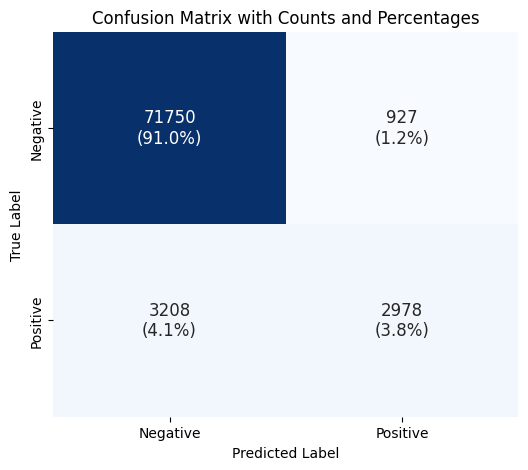

In [229]:
plot_confusion_matrix(y_test, y_pred)

In [231]:
# Create Feature Importance Table
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb.feature_importances_
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [232]:
feature_importance_df.head(10)

,Feature,Importance
486,education,43744.11
489,capital_gains,20115.52
493,weeks_worked_in_year,15993.37
172,sex_ Female,12376.87
491,dividends_from_stocks,12347.55
487,age,11451.74
490,capital_losses,6058.02
492,num_persons_worked_for_employer,3535.54
193,tax_filer_stat_ Joint both under 65,3199.66
195,tax_filer_stat_ Nonfiler,1928.54


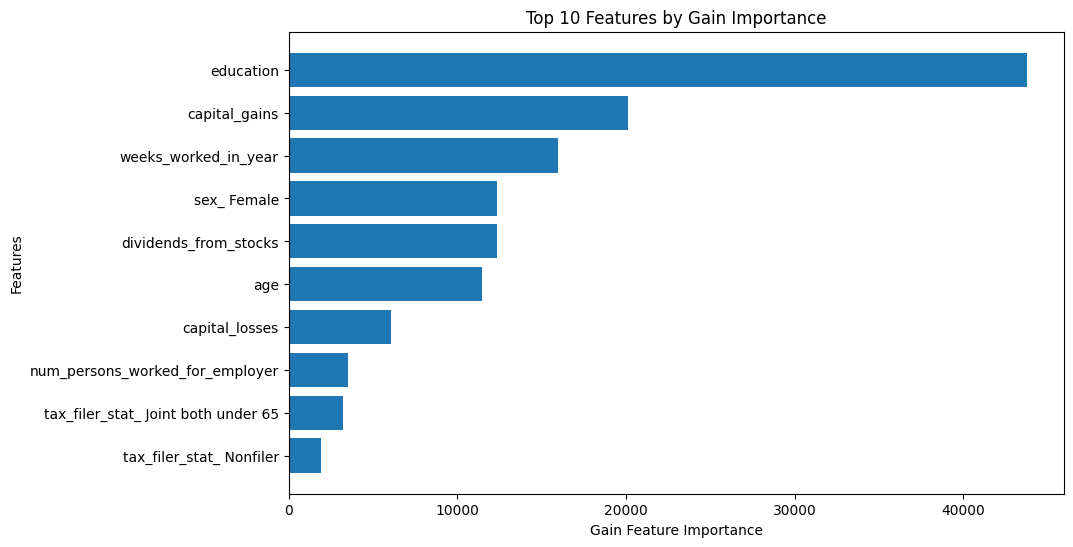

In [233]:
# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Gain Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Features by Gain Importance')
# To display the top feature at the top of the plot
plt.gca().invert_yaxis() 
plt.show()

## Conclusion


We selected LightGBM Classifier to predict whether an individual fell into the below $50K income class or above $50K income class. We used the combination of data processing and hyperparameter tuning to improve the model's performance.

Here are the model metrics:
- Accuracy: 0.9476
- F1 Score (Weighted): 0.942
- Precision: 0.9419
- Recall: 0.9476

We know that the test set has 93.8% of the target as being below $50K. A baseline model could be to predict the majority class and it would return an accuracy of 93.8%. Our model has an accuracy of 94.76% so we outperformed the baseline.

### Next steps

- Although model metrics looks good, there is still work to do when it comes to predicting above $50K income class.
- Explore missing values and best steps to impute them
- Seeing how transforming numerical columns to remove outliers and skweness would effect model performance.
- Seeing how rebinning categorical data would effect model performance.
- Fixing categories that don't map to both target classes.
- Creating more features and incorporating new data
- Different feature selection methods and the effect on model performance.
- Build a production-level ML pipeline with experiment tracking, orchestration, monitoring, CI/CD, etc.

